In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

try:
    # Load the full, scaled training and testing data
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
    y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

    # Drop the 'id' column if it exists
    if 'id' in X_train.columns:
        X_train = X_train.drop('id', axis=1)
        X_test = X_test.drop('id', axis=1)

    print("Data for tuning loaded successfully!")
    print("Training data shape:", X_train.shape)
except FileNotFoundError:
    print("Error: Processed data not found.")

Data for tuning loaded successfully!
Training data shape: (736, 21)


In [3]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 10, 20],             # Maximum depth of the tree
    'min_samples_split': [2, 5],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]               # Minimum number of samples required at a leaf node
}

# Initialize the base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
# cv=5 means we'll use 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores to speed up the process
# scoring='roc_auc' tells it to find the model with the best ROC AUC score
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit the grid search to the data
print("Starting GridSearchCV... This may take a few minutes.")
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Store the best estimator for the next step
best_model = grid_search.best_estimator_

Starting GridSearchCV... This may take a few minutes.
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


--- Final Model Evaluation on Test Data ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        82
           1       0.84      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

Final ROC AUC Score: 0.9258

--- ROC Curve ---


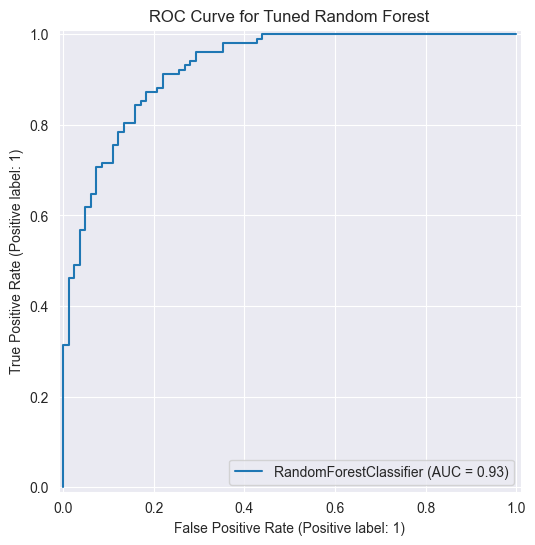

In [4]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Evaluate the best model on the test data
print("--- Final Model Evaluation on Test Data ---")
y_pred = best_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print ROC AUC Score
final_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"Final ROC AUC Score: {final_roc_auc:.4f}")

# Plot the ROC Curve
print("\n--- ROC Curve ---")
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
ax.set_title("ROC Curve for Tuned Random Forest")
plt.show()

In [5]:
import joblib
import os
from sklearn.preprocessing import StandardScaler

# --- Create a 'models' directory if it doesn't exist ---
os.makedirs('models', exist_ok=True)


# --- Save the Tuned Model ---
# The 'best_model' variable holds the best model found by GridSearchCV
joblib.dump(best_model, 'models/final_model.pkl')
print("✅ Tuned model saved successfully as 'final_model.pkl'")


# --- Re-fit and Save the Scaler ---
# We need to save the scaler that was fitted on the training data
# We'll re-create it here to ensure it's the correct one
cols_to_scale = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
scaler = StandardScaler()

# Re-fit the scaler on the original training data (X_train)
# This ensures it's perfectly matched with the trained model
scaler.fit(X_train[cols_to_scale])

joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Scaler saved successfully as 'scaler.pkl'")

✅ Tuned model saved successfully as 'final_model.pkl'
✅ Scaler saved successfully as 'scaler.pkl'
